<a href="https://colab.research.google.com/github/ishaan27chaturvedi/Text-Classification/blob/main/LSTM_and_CNN_using_GloVe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3 - Comparing Classification Models



---















In this session, we demonstrate how to solve a text classification task using simple 
feedforward neural network classifier. We will use IMDB Large Movie Review Dataset to train a binary classification model, able to predict whether a review is positive or negative. First, our network takes one-hot word vectors as input, averages them to make one vector and trains a 
fully-connected layer to predict the output. In the second part, we replace the one-hot vectors with the word embeddings and add a layer to see how much that improves the performance.

We are going to use Keras Sequential API in this session. The Sequential API allows you to make models layer-by-layer. But it is not straightforward to define models where layers connect to more than just the previous and next layers. 

In [ ]:
import tensorflow.keras as tk
import numpy as np
from keras.layers import Lambda, GlobalAveragePooling1D, Dense, Embedding
from keras import backend as K
from keras.models import Sequential
import matplotlib.pyplot as plt
import keras

### Downloading data

The dataset we will be using is the IMDB Large Movie Review Dataset, which consists of 50000 labeled movie reviews. These are split into 25,000 reviews for training and 25,000 reviews for testing. The  dataset contains an even number of positive and negative reviews, so randomly guessing yields 50% accuracy. The data is preprocessed. For text classification, it is ususal to limit the size of the vocabulary to stop the dataset from becoming too sparse, creating possible overfitting. We keep the top 10,000 most frequently occurring words in the training data.


In [ ]:
imdb = tk.datasets.imdb
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=10000)

We now can start playing around with the data, let’s first see the length:

In [ ]:
print("Training entries: {}, labels: {}".format(len(X_train), len(y_train)))

Training entries: 25000, labels: 25000


The  reviews have been converted to integers and each integer represents a  word in a dictionary. 

In [ ]:
 X_train[0][:10]

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]

We can convert integers back to words by querying a dictionary object that contains the integer to string mapping:

In [ ]:
word_index = imdb.get_word_index()

1654784/1641221 [==============================] - 0s 0us/step


Index 1 represents the beginning of the sentence and the index 2 is assigned to all unknown tokens. Index 0 will be used for padding.

In [ ]:
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  
word_index["<UNUSED>"] = 3

To reverse key and values in a dictionary:

In [ ]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

To view a word:

In [ ]:
reverse_word_index[25]

'you'

And to recreate the whole sentence from our training data we define decode_review:


In [ ]:
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [ ]:
decode_review(X_train[10])

"<START> french horror cinema has seen something of a revival over the last couple of years with great films such as inside and <UNK> romance <UNK> on to the scene <UNK> <UNK> the revival just slightly but stands head and shoulders over most modern horror titles and is surely one of the best french horror films ever made <UNK> was obviously shot on a low budget but this is made up for in far more ways than one by the originality of the film and this in turn is <UNK> by the excellent writing and acting that ensure the film is a winner the plot focuses on two main ideas prison and black magic the central character is a man named <UNK> sent to prison for fraud he is put in a cell with three others the quietly insane <UNK> body building <UNK> marcus and his retarded boyfriend daisy after a short while in the cell together they stumble upon a hiding place in the wall that contains an old <UNK> after <UNK> part of it they soon realise its magical powers and realise they may be able to use it

### Creating One-hot word vectors

It is  common to use one-hot representation as input in Natural Language Processing tasks. In Keras, the Embedding layer takes an index as an input and convert it to one-hot vector with the length of the vocabulary size. Then multiplies these vectors by a normal weight matrix. But there is no way to only get a one-hot vector as the output of a layer in Keras. To solve this we use Lambda() layer and a function that creates the one-hot layer. 

In [ ]:
def OneHot(input_dim=None, input_length=None):
    
    if input_dim is None or input_length is None:
        raise TypeError("input_dim or input_length is not set")

    
    def _one_hot(x, num_classes):
        return K.one_hot(K.cast(x, 'uint8'),
                          num_classes=num_classes)

    return Lambda(_one_hot,
                  arguments={'num_classes': input_dim},
                  input_shape=(input_length,))

input_dim refers to the length of the one-hot vector and input_length refers to the length of the input sequence. Since the input to K.one_hot should be an integer tensor, we cast x to one (Keras passes around float tensors by default).



 Each text sequence has in most cases different length of words. Here, we fill sequences with a pad token (0) to fit the size. This special tokens is then masked not to be accounted in averaging, loss calculation etc. We set the maximum length to 256.

### Preparing input data

In [ ]:
VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 256

X_train_enc = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=256)

X_test_enc = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=256)

And to view a padded review:

In [ ]:
print(X_train_enc[1])
print('\nLength: ',len(X_train_enc))

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    1  194 1153
  194 8255   78  228    5    6 1463 4369 5012  134   26    4  715    8
  118 1634   14  394   20   13  119  954  189  102    5  207  110 3103
   21   14   69  188    8   30   23    7    4  249  126   93    4  114
    9 2300 1523    5  647    4  116    9   35 8163    4  229    9  340
 1322    4  118    9    4  130 4901   19    4 1002    5   89   29  952
   46   37    4  455    9   45   43   38 1543 1905  398    4 1649   26
 6853    5  163   11 3215    2    4 1153    9  194  775    7 8255    2
  349 2637  148  605    2 8003   15  123  125   68    2 6853   15  349
  165 4362   98    5    4  228    9   43    2 1157   15  299  120    5
  120 

Now we want to build the neural network model. We  are going to have a hidden layer with 16 hidden units. 

First, we want to transform each index to an embedded vector and then average all vectors to a single one. It has been showed that unweighted average of word vectors outperforms many complicated networks that model semantic and syntactic compositionality. As an example you can take a look at this: (http://anthology.aclweb.org/P/P15/P15-1162.pdf)

To average we need to ignore padded zeros:

In [ ]:
class GlobalAveragePooling1DMasked(GlobalAveragePooling1D):
    def call(self, x, mask=None):
        if mask != None:
            return K.sum(x, axis=1) / K.sum(mask, axis=1)
        else:
            return super().call(x)


# Model 1: Neural averaging network using one-hot vectors

The first layer is an one-hot layer. The second layer is to compute average on all word vectors in a sentence without considering padding. The  output vector is piped through a fully-connected layer. The last layer is connected with a single output node with the sigmoid activation function. The final value is a float between 0 and 1. 
The vocabulary count of the movie reviews (10000) is used as the input shape. At the end we visualize the model summary.

In [ ]:
# your code goes here
from keras.layers import Input, Embedding, Dense, LSTM, Lambda, GlobalAveragePooling1D
from keras import backend as K
from keras.models import Model

EMBED_SIZE = 100

input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,))
onehot_layer = OneHot(VOCAB_SIZE, EMBED_SIZE)(input_layer)
pooling_layer = GlobalAveragePooling1DMasked()(onehot_layer)
hidden_dense_layer = Dense(16)(pooling_layer)
output_dense_layer = Dense(1, activation = 'sigmoid')(hidden_dense_layer)


### Training the model

To compile the model we need a loss function and an optimizer. We use binary_crossentropy loss function which is just a special case of categorical cross entropy. We also use Adam optimizer that can be used instead of the classical stochastic gradient descent procedure to update network weights iterative based in training data. You can read more about it here:
(https://arxiv.org/abs/1412.6980v8
)


In [ ]:
# your code goes here
model = Model(inputs=input_layer, outputs=output_dense_layer)
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256)]             0         
                                                                 
 lambda (Lambda)             (None, 256, 10000)        0         
                                                                 
 global_average_pooling1d_ma  (None, 10000)            0         
 sked (GlobalAveragePooling1                                     
 DMasked)                                                        
                                                                 
 dense (Dense)               (None, 16)                160016    
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable

*In the model, 
Add an input layer which accepts input with shape equal to 256 corresponding to the maximum length of padded sequences. 
The lambda layer which is used for the one hot representation which uses vocabulary size =10000 and embedding size =100 
The pooling layer as defined in the function 
Then a dense layer. 
Finally, the output dense layer with sigmoid activation function since we are expecting a binary output.*


When training, we want to check the accuracy of the model on data it hasn't seen before. So we create a validation set:

In [ ]:
X_val = np.array(X_train_enc[:10000])
partial_X_train = np.array(X_train_enc[10000:])

y_val = np.array(y_train[:10000])
partial_y_train = np.array(y_train[10000:])

Then we start to train the model for 40 epochs in mini-batches of 512 samples and monitor the model's loss and accuracy on the validation set.

In [ ]:
history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 6s 107ms/step - loss: 0.6923 - accuracy: 0.5303 - val_loss: 0.6916 - val_accuracy: 0.5115
Epoch 2/40
30/30 [==============================] - 3s 101ms/step - loss: 0.6902 - accuracy: 0.5796 - val_loss: 0.6892 - val_accuracy: 0.6580
Epoch 3/40
30/30 [==============================] - 3s 101ms/step - loss: 0.6875 - accuracy: 0.6566 - val_loss: 0.6864 - val_accuracy: 0.6565
Epoch 4/40
30/30 [==============================] - 3s 101ms/step - loss: 0.6841 - accuracy: 0.6646 - val_loss: 0.6827 - val_accuracy: 0.6674
Epoch 5/40
30/30 [==============================] - 3s 101ms/step - loss: 0.6800 - accuracy: 0.6649 - val_loss: 0.6786 - val_accuracy: 0.6642
Epoch 6/40
30/30 [==============================] - 3s 101ms/step - loss: 0.6752 - accuracy: 0.6740 - val_loss: 0.6741 - val_accuracy: 0.6713
Epoch 7/40
30/30 [==============================] - 3s 101ms/step - loss: 0.6704 - accuracy: 0.6677 - val_loss: 0.6688 - val_accuracy: 0.6710
Epoch 

### Evaluating the model

To evaulate the model on test data:

In [ ]:
results = model.evaluate(X_test_enc, y_test)

782/782 [==============================] - 5s 6ms/step - loss: 0.5347 - accuracy: 0.7426


In [ ]:
print(results)
# loss, accuracay 

[0.5346807241439819, 0.7426000237464905]


Our first model accuracy using one-hot vectors is ~68%







### Plotting the accuracy graph

To plot a graph of accuracy and loss over time we can use Matplotlib:

In [ ]:
pip install plot_keras_history

  Created wheel for plot-keras-history: filename=plot_keras_history-1.1.30-py3-none-any.whl size=8794 sha256=b458ecc796ff9c8df213a6ae7d3171f1bd575c5ae40a984b4c2af1cd7879d138
  Stored in directory: /root/.cache/pip/wheels/b0/60/47/8c5aa37c06be5e97879ec467bc2e6a30b315d95f662c63a503
  Created wheel for sanitize-ml-labels: filename=sanitize_ml_labels-1.0.29-py3-none-any.whl size=7878 sha256=9ecd7c793f172b8747f5fcda272e417467ea4ae22bfaeb17612dff7f1c59d658
  Stored in directory: /root/.cache/pip/wheels/c2/f5/71/d1c459da10abec864a1979b449edbf37d4a82ab3e38a3625a8
  Created wheel for compress-json: filename=compress_json-1.0.4-py3-none-any.whl size=4588 sha256=47fa93684d30221f3f0b6880ad2f46e80cf8906a18a879415a7fb8986b5b09f8
  Stored in directory: /root/.cache/pip/wheels/1e/ef/1e/5d403c5632b0462471a8d26049d0c138134d0255ec60ce4c14
Successfully built plot-keras-history sanitize-ml-labels compress-json


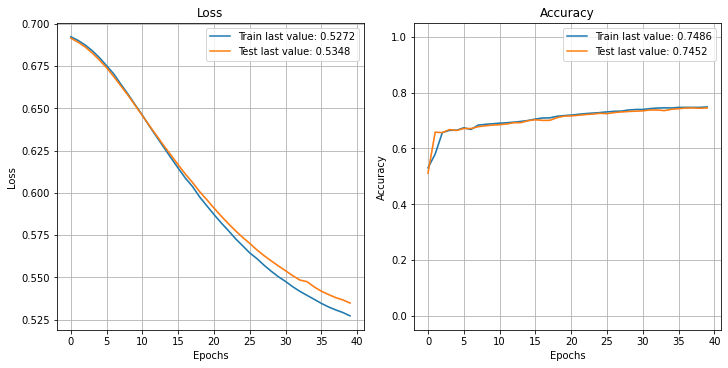

In [ ]:

from plot_keras_history import plot_history
import matplotlib.pyplot as plt
plot_history(history.history, path="standard.png")
plt.show()

*The loss and accuracy are consistent for both the training and validation data which is a good sign, as it shows that the model has not ovefit. Also, the accuracy of ~75% is good and higher than expected (68%)*

# Model 2: Neural averaging network using embedding layer

Now instead of one-hot vectors, we want to use embedding. We change our first layer in model1 to an Embedding layer. This layer takes the integer-encoded vocabulary and looks up the embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: (batch, sequence, embedding).

In [ ]:
# your code goes here

input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,))
embedding_layer = Embedding(input_length=MAX_SEQUENCE_LENGTH, input_dim=VOCAB_SIZE, output_dim=EMBED_SIZE, name='embed_layer',
                        embeddings_initializer='glorot_uniform')(input_layer)
pooling_layer = GlobalAveragePooling1DMasked()(embedding_layer)
hidden_dense_layer = Dense(16)(pooling_layer)
output_dense_layer = Dense(1, activation = 'sigmoid')(hidden_dense_layer)

model2 = Model(inputs=input_layer, outputs=output_dense_layer)
model2.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256)]             0         
                                                                 
 embed_layer (Embedding)     (None, 256, 100)          1000000   
                                                                 
 global_average_pooling1d_ma  (None, 100)              0         
 sked_1 (GlobalAveragePoolin                                     
 g1DMasked)                                                      
                                                                 
 dense_2 (Dense)             (None, 16)                1616      
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,001,633
Trainable params: 1,001,633
Non-tra

*This model takes an embedding layer instead of a one hot encoded layer*

In [ ]:
history = model2.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 1s 14ms/step - loss: 0.6860 - accuracy: 0.6710 - val_loss: 0.6741 - val_accuracy: 0.7155
Epoch 2/40
30/30 [==============================] - 0s 9ms/step - loss: 0.6485 - accuracy: 0.7346 - val_loss: 0.6204 - val_accuracy: 0.7404
Epoch 3/40
30/30 [==============================] - 0s 9ms/step - loss: 0.5740 - accuracy: 0.7779 - val_loss: 0.5404 - val_accuracy: 0.7830
Epoch 4/40
30/30 [==============================] - 0s 9ms/step - loss: 0.4827 - accuracy: 0.8226 - val_loss: 0.4593 - val_accuracy: 0.8232
Epoch 5/40
30/30 [==============================] - 0s 9ms/step - loss: 0.4003 - accuracy: 0.8589 - val_loss: 0.3964 - val_accuracy: 0.8488
Epoch 6/40
30/30 [==============================] - 0s 9ms/step - loss: 0.3398 - accuracy: 0.8807 - val_loss: 0.3570 - val_accuracy: 0.8600
Epoch 7/40
30/30 [==============================] - 0s 9ms/step - loss: 0.2960 - accuracy: 0.8942 - val_loss: 0.3314 - val_accuracy: 0.8702
Epoch 8/40
30/30 [=

In [ ]:
results = model2.evaluate(X_test_enc, y_test)

782/782 [==============================] - 2s 2ms/step - loss: 0.5951 - accuracy: 0.8535


In [ ]:
print (results)

[0.595098078250885, 0.8535199761390686]


*The models performance has significantly jumped up from 74% to 85.3%*

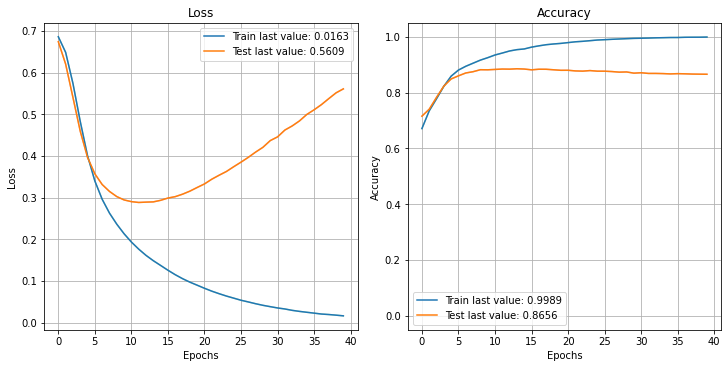

In [ ]:
plot_history(history.history, path="standard.png")
plt.show()

The accuracy of model2 is 87%. Using Embedding layer instead of one-hot layer improved the performance.

# Model 3: Using pre-trained word embeddings

### Preparing pre-trained word embeddings (GLOVE)

The Embedding layer can be used to load a pre-trained word embedding model. We are going to use GloVe embeddings, which you can read about it here (https://nlp.stanford.edu/projects/glove/). GloVe stands for "Global Vectors for Word Representation". It's a somewhat popular embedding technique based on factorizing a matrix of word co-occurence statistics. You can download GloVe and we can seed the Keras Embedding layer with weights from the pre-trained embedding for the words in your dataset.
First, we need to read GloVe and map words to GloVe:


In [ ]:
def readGloveFile(gloveFile):
    with open(gloveFile, 'r') as f:
        wordToGlove = {}  
        wordToIndex = {}  
        indexToWord = {}  

        for line in f:
            record = line.strip().split()
            token = record[0] 
            wordToGlove[token] = np.array(record[1:], dtype=np.float64) 
            
        tokens = sorted(wordToGlove.keys())
        for idx, tok in enumerate(tokens):
            kerasIdx = idx + 1  
            wordToIndex[tok] = kerasIdx 
            indexToWord[kerasIdx] = tok 

    return wordToIndex, indexToWord, wordToGlove

Now, we create our pre-trained Embedding layer:

In [ ]:
from keras.initializers import Constant

def createPretrainedEmbeddingLayer(wordToGlove, wordToIndex, isTrainable):
    vocabLen = len(wordToIndex) + 1  
    embDim = next(iter(wordToGlove.values())).shape[0]  
   
    embeddingMatrix = np.zeros((vocabLen, embDim))  
    for word, index in wordToIndex.items():
        embeddingMatrix[index, :] = wordToGlove[word] 

    embeddingLayer = Embedding(vocabLen, embDim, embeddings_initializer=Constant(embeddingMatrix), trainable=isTrainable, name='GloVe_Embeddings')
    return embeddingLayer

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip '/content/glove.6B.zip'

--2022-03-12 14:55:01--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-03-12 14:55:02--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-03-12 14:55:02--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

We freeze the weights. To create the model: 

In [ ]:
# wordToIndex,indexToWord,wordToGlove=readGloveFile('/content/glove.6B.50d.txt')
# wordToIndex,indexToWord,wordToGlove=readGloveFile('/content/glove.6B.100d.txt')
wordToIndex,indexToWord,wordToGlove=readGloveFile('/content/glove.6B.300d.txt')

# vocabLen = len(wordToIndex) + 1 

EMBED_SIZE = next(iter(wordToGlove.values())).shape[0]
print('Size of Embedding: ',EMBED_SIZE)

embeddingLayer=createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=False)

Size of Embedding:  300


## Model 3-1: Neural bag of words using pre-trained word embeddings

Now we change our model to use GloVe:

In [ ]:
# Inspect model performance with 1 hidden layer, pre-trained embeddings
# your code goes here

from keras.layers import Input, Embedding, Dense, Lambda, GlobalAveragePooling1D
from keras import backend as K
from keras.models import Model



input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,))
embedding_layer = embeddingLayer(input_layer)
pooling_layer = GlobalAveragePooling1DMasked()(embedding_layer)
hidden_dense_layer = Dense(16)(pooling_layer)
output_dense_layer = Dense(1, activation = 'sigmoid')(hidden_dense_layer)

model3_1 = Model(inputs=input_layer, outputs=output_dense_layer)
model3_1.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

model3_1.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256)]             0         
                                                                 
 GloVe_Embeddings (Embedding  (None, 256, 300)         120000300 
 )                                                               
                                                                 
 global_average_pooling1d_ma  (None, 300)              0         
 sked_2 (GlobalAveragePoolin                                     
 g1DMasked)                                                      
                                                                 
 dense_4 (Dense)             (None, 16)                4816      
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                           

*We are now using a pretrained embedded layer called GloVe. We are using the default values encoded as we have set training=False*

In [ ]:
# Train and test the model

history = model3_1.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 1s 11ms/step - loss: 0.6909 - accuracy: 0.5282 - val_loss: 0.6850 - val_accuracy: 0.5676
Epoch 2/40
30/30 [==============================] - 0s 6ms/step - loss: 0.6802 - accuracy: 0.5801 - val_loss: 0.6770 - val_accuracy: 0.5861
Epoch 3/40
30/30 [==============================] - 0s 6ms/step - loss: 0.6723 - accuracy: 0.5953 - val_loss: 0.6697 - val_accuracy: 0.5993
Epoch 4/40
30/30 [==============================] - 0s 6ms/step - loss: 0.6650 - accuracy: 0.6068 - val_loss: 0.6624 - val_accuracy: 0.6103
Epoch 5/40
30/30 [==============================] - 0s 6ms/step - loss: 0.6573 - accuracy: 0.6225 - val_loss: 0.6550 - val_accuracy: 0.6233
Epoch 6/40
30/30 [==============================] - 0s 6ms/step - loss: 0.6501 - accuracy: 0.6303 - val_loss: 0.6482 - val_accuracy: 0.6362
Epoch 7/40
30/30 [==============================] - 0s 6ms/step - loss: 0.6420 - accuracy: 0.6467 - val_loss: 0.6443 - val_accuracy: 0.6365
Epoch 8/40
30/30 [=

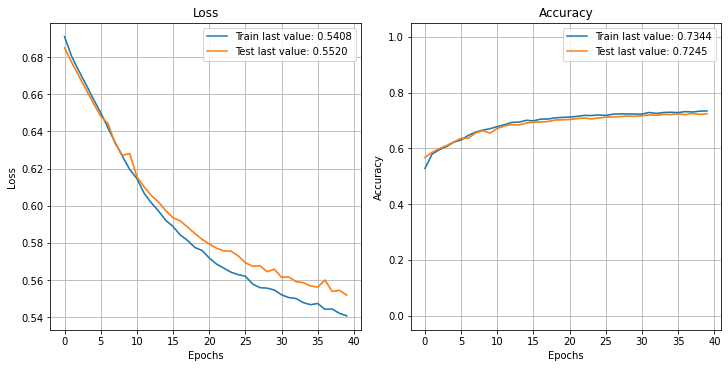

In [ ]:
plot_history(history.history, path="standard.png")
plt.show()

In [ ]:
results = model3_1.evaluate(X_test_enc, y_test)
print(results)

782/782 [==============================] - 2s 2ms/step - loss: 0.5540 - accuracy: 0.7186
[0.5539815425872803, 0.718559980392456]


*As you can see, the accuracy has dropped to its worst yet. This 71% is worse than the 74% achieved by the one hot encoded vector*

To compare freezing and fine-tuning the pre-train embedding weights, we fine-tune the weights here:

In [ ]:
# your code goes here
embeddingLayer=createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=True)

input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,))
embedding_layer = embeddingLayer(input_layer)
pooling_layer = GlobalAveragePooling1DMasked()(embedding_layer)
hidden_dense_layer = Dense(16)(pooling_layer)
output_dense_layer = Dense(1, activation = 'sigmoid')(hidden_dense_layer)

model3 = Model(inputs=input_layer, outputs=output_dense_layer)
model3.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

model3.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256)]             0         
                                                                 
 GloVe_Embeddings (Embedding  (None, 256, 300)         120000300 
 )                                                               
                                                                 
 global_average_pooling1d_ma  (None, 300)              0         
 sked_3 (GlobalAveragePoolin                                     
 g1DMasked)                                                      
                                                                 
 dense_6 (Dense)             (None, 16)                4816      
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                           

*We use the pretrained GloVe again, but this time setting the trainable=True. This helps in retraining on our training data to be able to better adapt to the vocabulary used in this problem dataset*

In [ ]:
# Train and test the model
history = model3.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 2s 45ms/step - loss: 0.6876 - accuracy: 0.5575 - val_loss: 0.6691 - val_accuracy: 0.6423
Epoch 2/40
30/30 [==============================] - 1s 40ms/step - loss: 0.6489 - accuracy: 0.6757 - val_loss: 0.6282 - val_accuracy: 0.6960
Epoch 3/40
30/30 [==============================] - 1s 40ms/step - loss: 0.5948 - accuracy: 0.7273 - val_loss: 0.5649 - val_accuracy: 0.7560
Epoch 4/40
30/30 [==============================] - 1s 40ms/step - loss: 0.5149 - accuracy: 0.7939 - val_loss: 0.4849 - val_accuracy: 0.8144
Epoch 5/40
30/30 [==============================] - 1s 40ms/step - loss: 0.4296 - accuracy: 0.8421 - val_loss: 0.4143 - val_accuracy: 0.8413
Epoch 6/40
30/30 [==============================] - 1s 40ms/step - loss: 0.3602 - accuracy: 0.8697 - val_loss: 0.3671 - val_accuracy: 0.8603
Epoch 7/40
30/30 [==============================] - 1s 40ms/step - loss: 0.3116 - accuracy: 0.8853 - val_loss: 0.3369 - val_accuracy: 0.8715
Epoch 8/40
30

In [ ]:
results = model3.evaluate(X_test_enc, y_test)
print(results)

782/782 [==============================] - 2s 2ms/step - loss: 0.6018 - accuracy: 0.8516
[0.6017966270446777, 0.8515599966049194]


*We get significantly better results by training the pretrained embedding layer. A jump from 71% to 85%.*

In [ ]:
pip install plot_keras_history

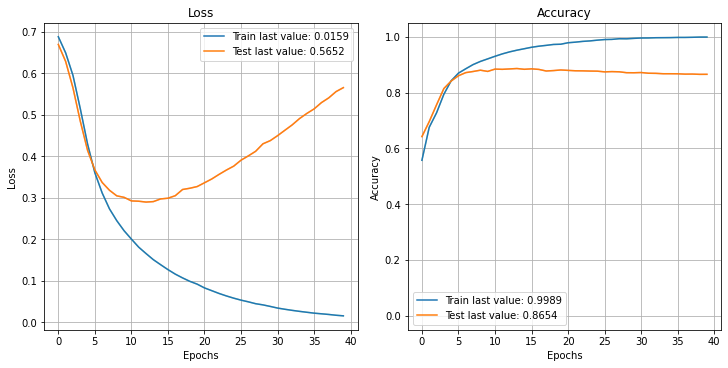

In [ ]:
from plot_keras_history import plot_history
import matplotlib.pyplot as plt
plot_history(history.history, path="standard.png")
plt.show()

Experiments here show that fine-tuning the pre-trained embeddings would obtain better accuracy.

Note that although fine-tuning the pre-trained embeddings is better here, we do not fine-tune it in other models. You could conduct extra experiments to compare the results.

##  Model 3-2: LSTM with pre-trained word embeddings

In previous labs, we have conducted an experiment based on LSTM. Now, we replace its embeddings with the GloVe pre-trained embeddings.

In [ ]:
# your code goes here
from keras.layers import Input, Embedding, Dense, LSTM, Dropout
from keras.models import Model

EMBED_SIZE = next(iter(wordToGlove.values())).shape[0]
# YOUR CODE GOES HERE
embeddingLayer=createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=False)

input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,))
embedding_layer = embeddingLayer(input_layer)
dropout_layer_1 = Dropout(rate=0.2)(embedding_layer)
lstm_layer = LSTM(100, return_sequences = False)(dropout_layer_1)
dropout_layer_2 = Dropout(rate=0.2)(lstm_layer)
hidden_dense_layer = Dense(16, activation = 'relu')(dropout_layer_2)
output_dense_layer = Dense(1, activation = 'sigmoid')(hidden_dense_layer)


model3_2 = Model(inputs= input_layer, outputs=output_dense_layer)
model3_2.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

model3_2.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 256)]             0         
                                                                 
 GloVe_Embeddings (Embedding  (None, 256, 300)         120000300 
 )                                                               
                                                                 
 dropout_4 (Dropout)         (None, 256, 300)          0         
                                                                 
 lstm_2 (LSTM)               (None, 100)               160400    
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense_12 (Dense)            (None, 16)                1616      
                                                           

*We attempt an LSTM model with frozen embedding, ie trainable=False*

In [ ]:
# Train and test the model
history = model3_2.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 4s 77ms/step - loss: 0.6803 - accuracy: 0.5579 - val_loss: 0.6549 - val_accuracy: 0.6014
Epoch 2/40
30/30 [==============================] - 2s 59ms/step - loss: 0.6217 - accuracy: 0.6525 - val_loss: 0.6234 - val_accuracy: 0.6590
Epoch 3/40
30/30 [==============================] - 2s 59ms/step - loss: 0.5816 - accuracy: 0.6925 - val_loss: 0.6111 - val_accuracy: 0.6901
Epoch 4/40
30/30 [==============================] - 2s 61ms/step - loss: 0.5528 - accuracy: 0.7175 - val_loss: 0.5251 - val_accuracy: 0.7408
Epoch 5/40
30/30 [==============================] - 2s 59ms/step - loss: 0.5222 - accuracy: 0.7403 - val_loss: 0.5900 - val_accuracy: 0.6792
Epoch 6/40
30/30 [==============================] - 2s 59ms/step - loss: 0.5110 - accuracy: 0.7466 - val_loss: 0.5118 - val_accuracy: 0.7486
Epoch 7/40
30/30 [==============================] - 2s 60ms/step - loss: 0.4764 - accuracy: 0.7681 - val_loss: 0.4655 - val_accuracy: 0.7768
Epoch 8/40
30

In [ ]:
results = model3_2.evaluate(X_test_enc, y_test)
print(results)

782/782 [==============================] - 7s 9ms/step - loss: 0.5030 - accuracy: 0.8460
[0.5029751062393188, 0.8460000157356262]


*This is quite a decent result given that we did not train the embedded layer*

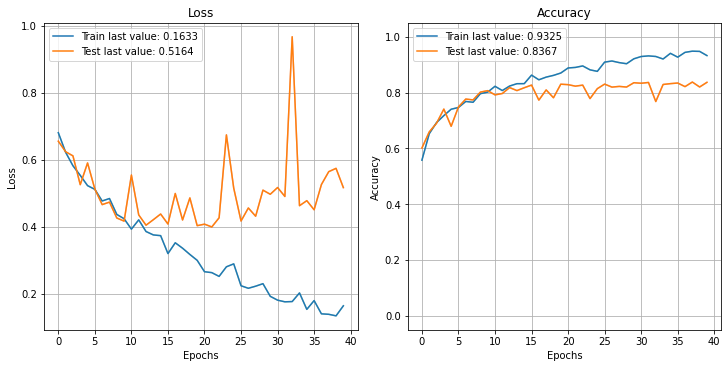

In [ ]:
from plot_keras_history import plot_history
import matplotlib.pyplot as plt
plot_history(history.history, path="standard.png")
plt.show()

Experiment show that simply replacing the lab 2 model embeddings with pre-trained word embeddings (GloVe) will cause performance to drop significantly. 
What can you do to improve the situation?

*To further improve this model we can attempt training the embedded layer as that boosts performance. We can also try early stopping as that helps reduce overfitting.*

In [ ]:
# your code goes here
from keras.layers import Input, Embedding, Dense, LSTM, Dropout
from keras.models import Model

EMBED_SIZE = next(iter(wordToGlove.values())).shape[0]
# YOUR CODE GOES HERE
embeddingLayer=createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=True)

input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,))
embedding_layer = embeddingLayer(input_layer)
dropout_layer_1 = Dropout(rate=0.2)(embedding_layer)
lstm_layer = LSTM(100, return_sequences = False)(dropout_layer_1)
dropout_layer_2 = Dropout(rate=0.2)(lstm_layer)
hidden_dense_layer = Dense(16, activation = 'relu')(dropout_layer_2)
output_dense_layer = Dense(1, activation = 'sigmoid')(hidden_dense_layer)


model3_2 = Model(inputs= input_layer, outputs=output_dense_layer)
model3_2.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

model3_2.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 256)]             0         
                                                                 
 GloVe_Embeddings (Embedding  (None, 256, 300)         120000300 
 )                                                               
                                                                 
 dropout_8 (Dropout)         (None, 256, 300)          0         
                                                                 
 lstm_4 (LSTM)               (None, 100)               160400    
                                                                 
 dropout_9 (Dropout)         (None, 100)               0         
                                                                 
 dense_16 (Dense)            (None, 16)                1616      
                                                           

*This time around the LSTM model has an embedded layer that will be retrained.*

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1, min_delta=0.01)

# Train and test the model
history = model3_2.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    callbacks = [callback])

Epoch 1/40
30/30 [==============================] - 5s 112ms/step - loss: 0.6785 - accuracy: 0.5502 - val_loss: 0.6459 - val_accuracy: 0.6258
Epoch 2/40
30/30 [==============================] - 3s 95ms/step - loss: 0.5956 - accuracy: 0.6777 - val_loss: 0.5526 - val_accuracy: 0.7148
Epoch 3/40
30/30 [==============================] - 3s 95ms/step - loss: 0.4506 - accuracy: 0.7913 - val_loss: 0.6976 - val_accuracy: 0.7082
Epoch 4/40
30/30 [==============================] - 3s 95ms/step - loss: 0.3820 - accuracy: 0.8355 - val_loss: 0.4555 - val_accuracy: 0.8282
Epoch 5/40
30/30 [==============================] - 3s 95ms/step - loss: 0.2946 - accuracy: 0.8797 - val_loss: 0.3514 - val_accuracy: 0.8516
Epoch 6/40
30/30 [==============================] - 3s 95ms/step - loss: 0.2348 - accuracy: 0.9076 - val_loss: 0.3927 - val_accuracy: 0.8586
Epoch 7/40
30/30 [==============================] - 3s 95ms/step - loss: 0.2107 - accuracy: 0.9209 - val_loss: 0.3748 - val_accuracy: 0.8573
Epoch 8/40
3

*We also used the early stopping callback*

In [ ]:
results = model3_2.evaluate(X_test_enc, y_test)
print(results)

782/782 [==============================] - 6s 8ms/step - loss: 0.3954 - accuracy: 0.8668
[0.39544913172721863, 0.8668000102043152]


*As you can see, this is the best result we have achieved so far at 86.6%*

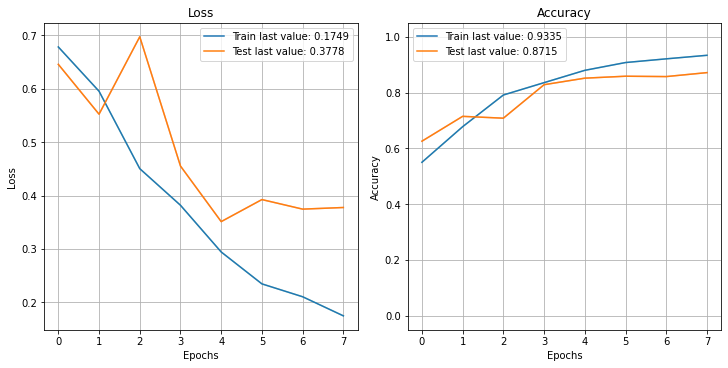

In [ ]:
from plot_keras_history import plot_history
import matplotlib.pyplot as plt
plot_history(history.history, path="standard.png")
plt.show()

#  Model 4: Adding extra dense layer into Neural averaging network model

We add extra dense layers into model 3-1 (neural network model) to evaluate extra dense layers' contribution. We start by adding one layer, then add two. All parameters are the same as model 3-1.

### Adding one extra dense layer

In [ ]:
# Inspect model performance with 1 hidden layer, pre-trained embeddings
# your code goes here

embeddingLayer=createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=True)

input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,))
embedding_layer = embeddingLayer(input_layer)
pooling_layer = GlobalAveragePooling1DMasked()(embedding_layer)
extra_dense_layer = Dense(100)(pooling_layer)
dense_layer = Dense(16)(extra_dense_layer)
output_dense_layer = Dense(1, activation='sigmoid')(dense_layer)

model4 = Model(inputs= input_layer, outputs=output_dense_layer)
model4.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
model4.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 256)]             0         
                                                                 
 GloVe_Embeddings (Embedding  (None, 256, 300)         120000300 
 )                                                               
                                                                 
 global_average_pooling1d_ma  (None, 300)              0         
 sked_5 (GlobalAveragePoolin                                     
 g1DMasked)                                                      
                                                                 
 dense_21 (Dense)            (None, 100)               30100     
                                                                 
 dense_22 (Dense)            (None, 16)                1616      
                                                          

*We use trainable embedded layer with the LSTM. But this time we have added an extra dense layer of 100 hidden neurons.*

In [ ]:
history = model4.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1,
                     callbacks = [callback])

Epoch 1/40
30/30 [==============================] - 2s 45ms/step - loss: 0.6754 - accuracy: 0.5847 - val_loss: 0.6488 - val_accuracy: 0.6408
Epoch 2/40
30/30 [==============================] - 1s 40ms/step - loss: 0.6032 - accuracy: 0.7015 - val_loss: 0.5462 - val_accuracy: 0.7483
Epoch 3/40
30/30 [==============================] - 1s 40ms/step - loss: 0.4602 - accuracy: 0.8061 - val_loss: 0.4239 - val_accuracy: 0.8117
Epoch 4/40
30/30 [==============================] - 1s 41ms/step - loss: 0.3412 - accuracy: 0.8567 - val_loss: 0.3437 - val_accuracy: 0.8572
Epoch 5/40
30/30 [==============================] - 1s 40ms/step - loss: 0.2682 - accuracy: 0.8941 - val_loss: 0.3170 - val_accuracy: 0.8714
Epoch 6/40
30/30 [==============================] - 1s 40ms/step - loss: 0.2165 - accuracy: 0.9170 - val_loss: 0.3047 - val_accuracy: 0.8771
Epoch 7/40
30/30 [==============================] - 1s 40ms/step - loss: 0.1802 - accuracy: 0.9327 - val_loss: 0.3045 - val_accuracy: 0.8797
Epoch 8/40
30

In [ ]:
results = model4.evaluate(X_test_enc, y_test)
print(results)

782/782 [==============================] - 2s 3ms/step - loss: 0.3549 - accuracy: 0.8672
[0.3548524081707001, 0.8672000169754028]


*This has topped the previous result of 86.6% by 0.1%. Our newest and best result so far at 86.7%*

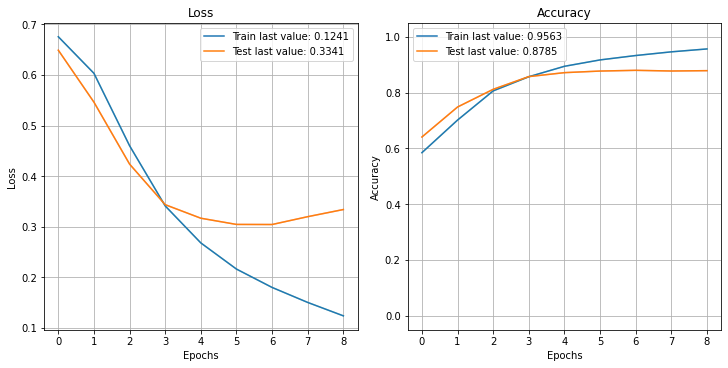

In [ ]:
from plot_keras_history import plot_history
import matplotlib.pyplot as plt
plot_history(history.history, path="standard.png")
plt.show()

### Adding two extra dense layers

In [ ]:
# Inspect model performance with 1 hidden layer, pre-trained embeddings
# your code goes here

embeddingLayer=createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=True)

input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,))
embedding_layer = embeddingLayer(input_layer)
pooling_layer = GlobalAveragePooling1DMasked()(embedding_layer)
extra_dense_layer_1 = Dense(300, activation='relu')(pooling_layer)
extra_dense_layer_2 = Dense(100, activation='relu')(extra_dense_layer_1)
dense_layer = Dense(16, activation='relu')(extra_dense_layer_2)
output_dense_layer = Dense(1, activation='sigmoid')(dense_layer)

model4_2 = Model(inputs= input_layer, outputs=output_dense_layer)
model4_2.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
model4_2.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 256)]             0         
                                                                 
 GloVe_Embeddings (Embedding  (None, 256, 300)         120000300 
 )                                                               
                                                                 
 global_average_pooling1d_ma  (None, 300)              0         
 sked_8 (GlobalAveragePoolin                                     
 g1DMasked)                                                      
                                                                 
 dense_32 (Dense)            (None, 300)               90300     
                                                                 
 dense_33 (Dense)            (None, 100)               30100     
                                                          

*This time we have addded two extra hidden layers with relu activation of 300 and 100 hidden neurons respectively*

In [ ]:
history = model4_2.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    callbacks=[callback])

Epoch 1/40
30/30 [==============================] - 2s 46ms/step - loss: 0.6859 - accuracy: 0.5577 - val_loss: 0.6712 - val_accuracy: 0.6117
Epoch 2/40
30/30 [==============================] - 1s 41ms/step - loss: 0.6379 - accuracy: 0.6531 - val_loss: 0.6089 - val_accuracy: 0.6789
Epoch 3/40
30/30 [==============================] - 1s 41ms/step - loss: 0.5146 - accuracy: 0.7668 - val_loss: 0.4437 - val_accuracy: 0.8056
Epoch 4/40
30/30 [==============================] - 1s 41ms/step - loss: 0.3771 - accuracy: 0.8428 - val_loss: 0.3687 - val_accuracy: 0.8422
Epoch 5/40
30/30 [==============================] - 1s 40ms/step - loss: 0.2913 - accuracy: 0.8829 - val_loss: 0.3280 - val_accuracy: 0.8672
Epoch 6/40
30/30 [==============================] - 1s 41ms/step - loss: 0.2385 - accuracy: 0.9073 - val_loss: 0.3365 - val_accuracy: 0.8633
Epoch 7/40
30/30 [==============================] - 1s 41ms/step - loss: 0.1913 - accuracy: 0.9277 - val_loss: 0.3128 - val_accuracy: 0.8764
Epoch 8/40
30

In [ ]:
results = model4_2.evaluate(X_test_enc, y_test)
print(results)

782/782 [==============================] - 2s 3ms/step - loss: 0.3799 - accuracy: 0.8655
[0.3798668682575226, 0.8654800057411194]


*As we can see, the added relu activated dense layers are helping a little bit. But no major significant boosts.*

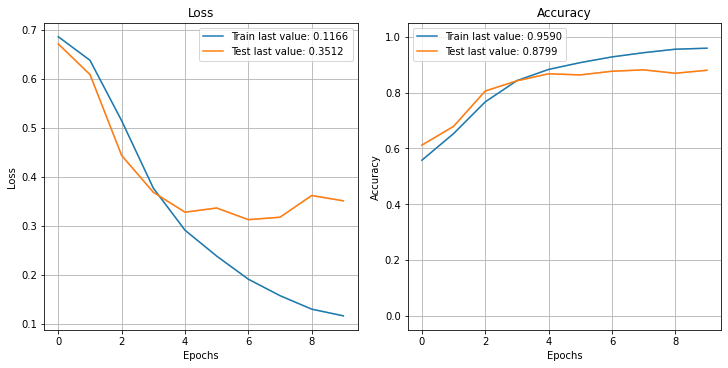

In [ ]:
from plot_keras_history import plot_history
import matplotlib.pyplot as plt
plot_history(history.history, path="standard.png")
plt.show()

These two experiments show that adding extra dense layers can slightly improve accuracy over model 3-1.

---



#  Model 5: CNN for Text Classification

In this section, we build a Convolutional Neural Network (CNN) for text classification. We start by using one CNN layer and then adding another layer. You could use embeddings from pre-trained or scratch.

##  Model 5-1: Basic CNN model for Text Classification 

In [ ]:
hidden_layer=16

# your code goes here

from keras.layers import Conv1D

embeddingLayer=createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=True)

input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,))
embedding_layer = embeddingLayer(input_layer)
conv_layer = Conv1D(100, 3)(embedding_layer)
pooling_layer = GlobalAveragePooling1DMasked()(conv_layer)
output_dense_layer = Dense(1, activation='sigmoid')(pooling_layer)

model5_1 = Model(inputs= input_layer, outputs=output_dense_layer)
model5_1.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
model5_1.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 256)]             0         
                                                                 
 GloVe_Embeddings (Embedding  (None, 256, 300)         120000300 
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 254, 100)          90100     
                                                                 
 global_average_pooling1d_ma  (None, 100)              0         
 sked_9 (GlobalAveragePoolin                                     
 g1DMasked)                                                      
                                                                 
 dense_36 (Dense)            (None, 1)                 101       
                                                          

*We now use a Convolutional layer instead of an LSTM layer*

In [ ]:
# Train and test the model

# your code goes here
history = model5_1.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    callbacks = [callback])

Epoch 1/40
30/30 [==============================] - 8s 67ms/step - loss: 0.6764 - accuracy: 0.5687 - val_loss: 0.6425 - val_accuracy: 0.6416
Epoch 2/40
30/30 [==============================] - 2s 59ms/step - loss: 0.5970 - accuracy: 0.7013 - val_loss: 0.5462 - val_accuracy: 0.7467
Epoch 3/40
30/30 [==============================] - 2s 60ms/step - loss: 0.4687 - accuracy: 0.8018 - val_loss: 0.4276 - val_accuracy: 0.8150
Epoch 4/40
30/30 [==============================] - 2s 59ms/step - loss: 0.3583 - accuracy: 0.8527 - val_loss: 0.3667 - val_accuracy: 0.8436
Epoch 5/40
30/30 [==============================] - 2s 60ms/step - loss: 0.2848 - accuracy: 0.8875 - val_loss: 0.3244 - val_accuracy: 0.8651
Epoch 6/40
30/30 [==============================] - 2s 59ms/step - loss: 0.2378 - accuracy: 0.9086 - val_loss: 0.3072 - val_accuracy: 0.8748
Epoch 7/40
30/30 [==============================] - 2s 60ms/step - loss: 0.2019 - accuracy: 0.9235 - val_loss: 0.3015 - val_accuracy: 0.8800
Epoch 8/40
30

782/782 [==============================] - 2s 3ms/step - loss: 0.3307 - accuracy: 0.8686
[0.3306501507759094, 0.8685600161552429]


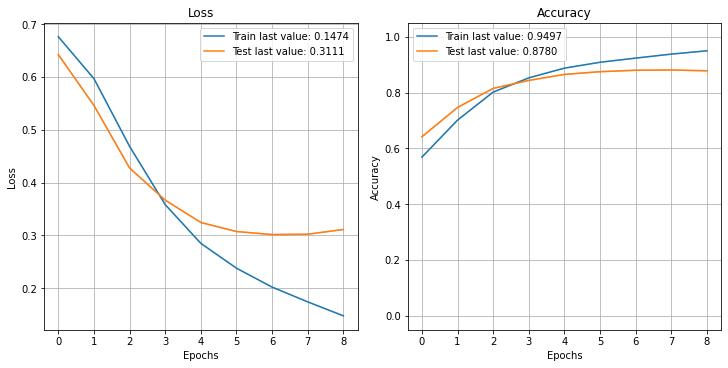

In [ ]:
# your code goes here
results = model5_1.evaluate(X_test_enc, y_test)

print (results)

from plot_keras_history import plot_history
import matplotlib.pyplot as plt
plot_history(history.history, path="standard.png")
plt.show()

*This has given us quite great results. At 86.8% this is our highest score yet*

## Model 5-2: Adding extra convolutional layer

In [ ]:

# your code goes here

from keras.layers import Conv1D

embeddingLayer=createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=True)

input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,))
embedding_layer = embeddingLayer(input_layer)
conv_layer1 = Conv1D(100, 6)(embedding_layer)
conv_layer2 = Conv1D(100, 3)(conv_layer1)
pooling_layer = GlobalAveragePooling1DMasked()(conv_layer2)
output_dense_layer = Dense(1, activation='sigmoid')(pooling_layer)

model5_2 = Model(inputs= input_layer, outputs=output_dense_layer)
model5_2.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
model5_2.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 256)]             0         
                                                                 
 GloVe_Embeddings (Embedding  (None, 256, 300)         120000300 
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 251, 100)          180100    
                                                                 
 conv1d_2 (Conv1D)           (None, 249, 100)          30100     
                                                                 
 global_average_pooling1d_ma  (None, 100)              0         
 sked_10 (GlobalAveragePooli                                     
 ng1DMasked)                                                     
                                                          

*Now we have added 2 convolutional layers with filter sizes 6 and 3 respectively*

In [ ]:
# Train and test the model

# your code goes here
history = model5_2.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    callbacks = [callback])

Epoch 1/40
30/30 [==============================] - 4s 85ms/step - loss: 0.7124 - accuracy: 0.5133 - val_loss: 0.6721 - val_accuracy: 0.6039
Epoch 2/40
30/30 [==============================] - 2s 76ms/step - loss: 0.6262 - accuracy: 0.6528 - val_loss: 0.5436 - val_accuracy: 0.7348
Epoch 3/40
30/30 [==============================] - 2s 76ms/step - loss: 0.4385 - accuracy: 0.8009 - val_loss: 0.4009 - val_accuracy: 0.8258
Epoch 4/40
30/30 [==============================] - 2s 75ms/step - loss: 0.3139 - accuracy: 0.8691 - val_loss: 0.3656 - val_accuracy: 0.8494
Epoch 5/40
30/30 [==============================] - 2s 75ms/step - loss: 0.2466 - accuracy: 0.9042 - val_loss: 0.3431 - val_accuracy: 0.8635
Epoch 6/40
30/30 [==============================] - 2s 75ms/step - loss: 0.1893 - accuracy: 0.9283 - val_loss: 0.3359 - val_accuracy: 0.8720
Epoch 7/40
30/30 [==============================] - 2s 75ms/step - loss: 0.1494 - accuracy: 0.9451 - val_loss: 0.4407 - val_accuracy: 0.8539
Epoch 8/40
30

782/782 [==============================] - 2s 3ms/step - loss: 0.4478 - accuracy: 0.8516
[0.4478025436401367, 0.8515599966049194]


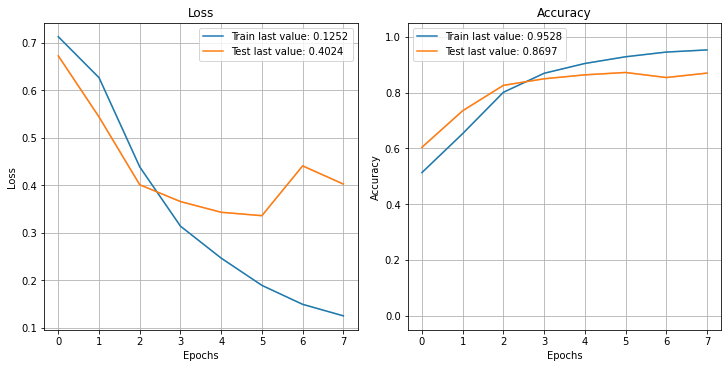

In [ ]:
# your code goes here
results = model5_2.evaluate(X_test_enc, y_test)

print (results)

from plot_keras_history import plot_history
import matplotlib.pyplot as plt
plot_history(history.history, path="standard.png")
plt.show()

Although adding layer here reduces the training loss, the evaluation accuracy is worse than the model without the extra convolutional layer.

Adding more layers can help you to extract more features. But we can do that up to a certain extent. After some point, instead of extracting features, we tend to overfit the data. Overfitting can lead to errors in on form or another, such as false positives. It is not easy to choose the number of units in a hidden layer or the number of hidden layers in a neural network. For many applications, one hidden layer is enough. As a general rule, the number of units in that hidden layer is between the number of inputs and the number of outputs.
 The best way to decide on the number of units and hidden layers is to try various parameters. Train several neural networks with different numbers of hidden layers and neurons, and monitor the performance of them. You will have to experiment using a series of different architectures. 







---

